In [1]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt

In [ ]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 20000
N_test = 10000
checkpoint_interval = 10
sigma = 0

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = 32
n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 1
sigma = 0

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)
optimizer = SGD_Momentum(lr=0.01, mu=0.6)

monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval,
        checkpoint_optimizer=True)

In [2]:
file_name = 'og_rflo'

In [ ]:
### --- SAVE RUN --- ###
with open(os.path.join('saved_runs/', file_name), 'wb') as f:
    saved_run = {'sim': sim, 'task': task}
    pickle.dump(saved_run, f)

In [3]:
### --- OPEN RUN --- ###
with open(os.path.join('saved_runs/', file_name), 'rb') as f:
    saved_run = pickle.load(f)
    sim = saved_run['sim']
    task =saved_run['task']

In [ ]:
!ls ../results

In [ ]:
!ls /scratch/oem214/vanilla-rtrl/wrappers/analyze_main.py /scratch/oem214/learning-dynamics/cluster_main_scripts/

In [ ]:
topological_analysis(file_name, FP_KE_criterion=0.00001, FP_N=1200, ppn=16,
                     n_checkpoints_per_job_=10,
                     compare_weight_change_alignment=False,
                     compare_node_diff=True,
                     compare_aligned_graph=True,
                     compare_n_comp_window=1,
                     test_N=1200, test_save_data=True,
                     compare_PC2=True, compare_CKA=True)

In [ ]:
topological_analysis(file_name, FP_KE_criterion=0.00001, FP_N=600, test_N=1200, test_save_data=True,
                     compare_PC1=False, compare_PC2=True, compare_PC3=False, compare_CKA=True)

In [ ]:
topological_analysis(file_name, FP_find_FPs=False, compare_align_checkpoints=False, compare_aligned_graph=False,
                     compare_node_diff=False, compare_node_drift=False,
                     test_N=2000, test_save_data=True,
                     compare_CKA=True, compare_PC1=True, compare_PC2=True, compare_PC3=True)

In [4]:
###Get job status
get_ipython().system('squeue -u oem214')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          13705443        cm  jupyter   oem214  R      13:35      1 cm005
      13700714_[1]     cm,cs compare_   oem214 PD       0:00      1 (Dependency)
      13700713_200        cs analyze_   oem214  R       1:48      1 cs223
      13700713_178        cs analyze_   oem214  R       5:50      1 cs227
      13700713_179        cs analyze_   oem214  R       5:50      1 cs234
      13700713_180        cs analyze_   oem214  R       5:50      1 cs243
      13700713_181        cs analyze_   oem214  R       5:50      1 cs249
      13700713_182        cs analyze_   oem214  R       5:50      1 cs251
      13700713_183        cs analyze_   oem214  R       5:50      1 cs263
      13700713_184        cs analyze_   oem214  R       5:50      1 cs267
      13700713_185        cs analyze_   oem214  R       5:50      1 cs288
      13700713_186        cs analyze_   oem214  R       5:50      1 cs299
      13700713_187  

In [ ]:
!scancel 11590921

In [ ]:
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')

In [ ]:
TD_means = []
TD_stds = []
indices = []
for i_checkpoint in range(5000, 5020, 10):

    file_name = 'robustness_2_cp_{}'.format(i_checkpoint)
    try:
        signals = unpack_compare_result(file_name, checkpoint_stats={'test_loss': get_checkpoint_loss})
    except FileNotFoundError:
        continue
    
    TD_means.append(signals['aligned_graph_distances'].mean())
    TD_stds.append(signals['aligned_graph_distances'].std())
    indices.append(i_checkpoint)


In [ ]:
plt.figure()
with open('/scratch/oem214/learning-dynamics/results/compare_cka_dense_test/result_0', 'rb') as f:
    result = pickle.load(f)
M = result['aligned_graph_distances']
plt.imshow(M + M.T)

In [ ]:
### --- SVCCA Check --- ###

def SVCCA_distance_(checkpoint_1, checkpoint_2, R=32):
    """Compute the singular-value canonical correlation analysis distance
    between two different networks."""

    A_1 = checkpoint_1['test_data']
    A_2 = checkpoint_2['test_data']

    #U_1, S_1, V_1 = np.linalg.svd(A_1)
    #U_2, S_2, V_2 = np.linalg.svd(A_2)

    cca = CCA(n_components=R, max_iter=1000)
    #cca.fit(V_1, V_2)
    #cca.fit(A_1.dot(V_1), A_2.dot(V_2))
    cca.fit(A_1, A_2)

    #return 1 - cca.score(A_1.dot(V_1), A_2.dot(V_2))
    #return 1 - cca.score(V_1, V_2)
    return 1 - cca.score(A_1, A_2)

In [ ]:
data = task.gen_data(0, 1000)
A_1 = get_test_sim_data(checkpoint_1, data)
A_2 = get_test_sim_data(checkpoint_2, data)

In [ ]:
checkpoint_1 = checkpoints['checkpoint_19000']
checkpoint_2 = checkpoints['checkpoint_18900']

align_checkpoints_based_on_output(checkpoint_2, checkpoint_1)
plot_input_dependent_topology(checkpoint_1)
plot_input_dependent_topology(checkpoint_2, graph_key='backembed_adjmat')

In [ ]:
def CKA_distance_(checkpoint_1, checkpoint_2, data, centered=False):
    """Compute CKA distance between two checkpoints"""

    A_1 = get_test_sim_data(checkpoint_1, data)
    A_2 = get_test_sim_data(checkpoint_2, data)

    N = A_1.shape[0]

    if centered:
        A_1 = A_1 - np.mean(A_1, axis=0)
        A_2 = A_2 - np.mean(A_2, axis=0)

    return 1 - (norm(A_1.T.dot(A_2)) / (norm(A_1.T.dot(A_1)) * norm(A_2.T.dot(A_2))))
    #return 1 - (norm(A_1.dot(A_2.T)) / (norm(A_1.dot(A_1.T)) * norm(A_2.dot(A_2.T))))

In [ ]:
CKA_distance(checkpoint_1, checkpoint_2, data, centered=False)

In [ ]:
sigma=0
a_init = np.random.normal(0, 0.1, 32)
rnn = deepcopy(checkpoint_1['rnn'])
test_sim = Simulation(rnn)
test_sim.run(data, mode='test',
             monitors=['rnn.a'],
             verbose=False,
             a_initial=a_init,
             sigma=sigma)
A_1 = test_sim.mons['rnn.a'].copy()


rnn = deepcopy(checkpoint_2['rnn'])
test_sim = Simulation(rnn)
test_sim.run(data, mode='test',
             monitors=['rnn.a'],
             verbose=False,
             a_initial=a_init,
             sigma=sigma)
A_2 = test_sim.mons['rnn.a'].copy()

centered = False
if centered:
    A_1 = A_1 - np.mean(A_1, axis=0)
    A_2 = A_2 - np.mean(A_2, axis=0)

1 - (norm(A_1.T.dot(A_2)) / (norm(A_1.T.dot(A_1)) * norm(A_2.T.dot(A_2))))

#cca = CCA(n_components=3)
#cca.fit(A_1, A_2)
#cca.score(A_1, A_2)

In [ ]:
norm(A_2.T.dot(A_2))

In [ ]:
M = result['aligned_graph_distances']
plt.hist((M + M.T).flatten())

In [ ]:
#Cross checkpoint

### 1 ###

saved_run_name = 'robustness_2_cp_5000'
analysis_job_name = 'analyze_{}'.format(saved_run_name)
compare_job_name = 'compare_{}'.format(saved_run_name)

results_dir = '/scratch/oem214/learning-dynamics/results/'

analysis_result_path = os.path.join(results_dir, analysis_job_name)
indices_1, checkpoints_1 = unpack_analysis_results(analysis_result_path)

### 2 ####

saved_run_name = 'robustness_2_cp_5010'
analysis_job_name = 'analyze_{}'.format(saved_run_name)
compare_job_name = 'compare_{}'.format(saved_run_name)

results_dir = '/scratch/oem214/learning-dynamics/results/'

analysis_result_path = os.path.join(results_dir, analysis_job_name)
indices_2, checkpoints_2 = unpack_analysis_results(analysis_result_path)

In [ ]:
M = np.zeros((len(indices_1), len(indices_2)))

for i in range(len(indices_1)):
    for j in range(len(indices_2)):
        
        i_index = indices_1[i]
        j_index = indices_2[j]

        checkpoint_1 = checkpoints_1['checkpoint_{}'.format(i_index)]
        checkpoint_2 = checkpoints_2['checkpoint_{}'.format(j_index)]

        align_checkpoints(checkpoint_2, checkpoint_1, n_inputs=6)
        align_checkpoints(checkpoint_2, checkpoint_1, n_inputs=6)
        
        M[i, j] = aligned_graph_distance(checkpoint_1, checkpoint_2)

In [ ]:
M.mean()

In [ ]:
same = result['aligned_graph_distances']
(same + same.T).mean()

In [ ]:
!mkdir figs/scheduling

In [4]:
#file_name = 'DNI_dynamics_3'
file_name = 'og_rflo'
saved_run_name = file_name
analysis_job_name = 'analyze_{}'.format(saved_run_name)
compare_job_name = 'compare_{}'.format(saved_run_name)

results_dir = '/scratch/oem214/learning-dynamics/results/'

analysis_result_path = os.path.join(results_dir, analysis_job_name)
indices, checkpoints = unpack_analysis_results(analysis_result_path)
signals = unpack_compare_result(file_name, checkpoint_stats={'test_loss': get_checkpoint_loss})

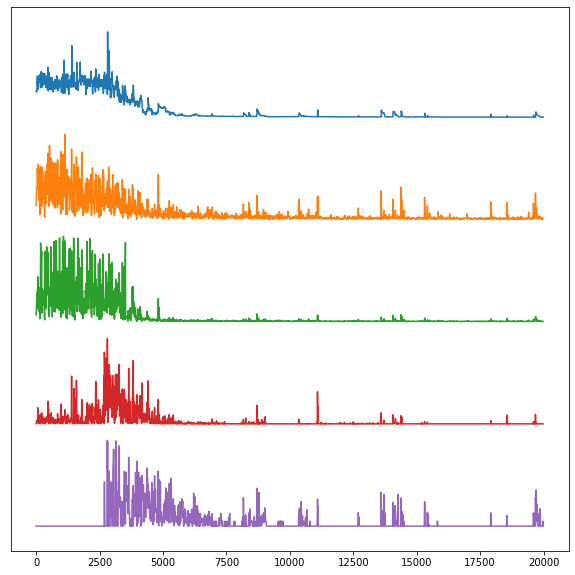

In [5]:
#import matplotlib
#matplotlib.rcParams['pdf.fonttype'] = 42
#matplotlib.rcParams['ps.fonttype'] = 42
fig = plot_signals(signals, x_values=indices, key_restriction=['test_loss', 'rec_weight_distances',
                                                               'PC2_distances', 'CKA_distances',
                                                               'aligned_graph_distances'],
                   signal_clips={'rec_weight_distances': 10}, legend=False)
figs_path = 'figs/talk_1-12/'
#plt.xlim([11000, 20000])
fig.savefig(os.path.join(figs_path, 'rflo_anecdote_2.pdf'.format(file_name)), format='pdf')

In [ ]:
with open('../results/compare_schedule_align/result_0', 'rb') as f:
    result = pickle.load(f)
    
M = result['aligned_graph_distances']
M = M + M.T

i = 1100

#plt.imshow(M[i-30:i+30, i-30:i+30])

In [ ]:
np.amax(signals['aligned_graph_distances'])

In [ ]:
fig = plt.figure()
indices_array = np.array(indices[:-1])
plt.plot(list(range(20000, 21000)), signals['aligned_graph_distances'][np.logical_and(indices_array >= 20000, indices_array < 21000)])
plt.xlim([20000, 20100])
plt.plot(list(range(20000, 21000)), 100 * signals['rec_weight_distances'][np.logical_and(indices_array >= 20000, indices_array < 21000)], color='C3')
plt.legend(['aligned_graph_distances', 'rec_weight_distanes'])
figs_path = 'figs/scheduling/'
fig.savefig(os.path.join(figs_path, 'detailed_changes.pdf'), format='pdf')

fig = plt.figure()
plt.plot(signals['aligned_graph_distances'][np.logical_and(indices_array >= 20000, indices_array < 21000)],
         100 * signals['rec_weight_distances'][np.logical_and(indices_array >= 20000, indices_array < 21000)], '.')
plt.xlabel('Topology')
plt.ylabel('Rec weight')
figs_path = 'figs/scheduling/'
fig.savefig(os.path.join(figs_path, 'scatter.pdf'), format='pdf')




In [ ]:
with open('../results/compare_schedule_test_4/result_0', 'rb') as f:
    result = pickle.load(f)

In [ ]:
for i_index, index in enumerate(indices):
    
    if i_index == 0:
        continue
    
    checkpoint_1 = checkpoints['checkpoint_{}'.format(index)]
    checkpoint_2 = checkpoints['checkpoint_{}'.format(indices[i_index - 1])]
    align_checkpoints_based_on_output(checkpoint_2, checkpoint_1)

plot_input_dependent_topology(checkpoints['checkpoint_20001'])
plot_input_dependent_topology(checkpoints['checkpoint_20002'])
plot_input_dependent_topology(checkpoints['checkpoint_20003'])
print('Distance from next = {}'.format(result['aligned_graph_distances'][indices.index(20003),
                                                                         indices.index(20004)]))
plot_input_dependent_topology(checkpoints['checkpoint_20004'])
print('Distance from next = {}'.format(result['aligned_graph_distances'][indices.index(20004),
                                                                         indices.index(20005)]))
plot_input_dependent_topology(checkpoints['checkpoint_20005'])
plot_input_dependent_topology(checkpoints['checkpoint_20006'])

In [ ]:
figs_path = 'figs/scheduling/'
for i in range(20001, 20015):
    print('Distance from next = {}'.format(result['aligned_graph_distances'][indices.index(i-1),
                                                                             indices.index(i)]))
    
    checkpoint_1 = checkpoints['checkpoint_{}'.format(i - 1)]
    checkpoint_2 = checkpoints['checkpoint_{}'.format(i)]
    align_checkpoints_based_on_output(checkpoint_2, checkpoint_1)
    fig = plot_input_dependent_topology(checkpoint_1, return_fig=True)
    fig.suptitle('Distance = {}'.format(aligned_graph_distance(checkpoint_1, checkpoint_2, node_diff_penalty=0)))
    fig.savefig(os.path.join(figs_path, 'cp_{}_1.pdf'.format(i - 1)), format='pdf')
                 
    align_checkpoints_based_on_output(checkpoint_1, checkpoint_2)
    fig = plot_input_dependent_topology(checkpoint_2, return_fig=True)
    fig.suptitle('Distance = {}'.format(aligned_graph_distance(checkpoint_1, checkpoint_2, node_diff_penalty=0)))
    fig.savefig(os.path.join(figs_path, 'cp_{}_2.pdf'.format(i)), format='pdf')
    #plt.close()
    

In [ ]:
indices.index(20000)

In [ ]:
i = 1
j = i + 1
print(result['aligned_graph_distances'][200 + i, 200 + j])
print(signals['aligned_graph_distances'][200 + i])
checkpoint_1 = checkpoints['checkpoint_{}'.format(20000 + i)]
checkpoint_2 = checkpoints['checkpoint_{}'.format(20000 + j)]
align_checkpoints_based_on_output(checkpoint_2, checkpoint_1)
print(aligned_graph_distance(checkpoint_1, checkpoint_2))

In [ ]:
indices.index(20000)

In [ ]:
!mkdir figs/fp_regime

In [ ]:
figs_path = 'figs/fp_regime/'
fig = plt.figure()
plt.hist(checkpoint['cluster_means'].flatten(), bins=30)
plt.xlabel('a_i value')
plt.ylabel('Count')
fig.savefig(os.path.join(figs_path, 'a_hist.pdf'), dpi=300, format='pdf')

In [ ]:
figs_path = 'figs/fp_regime/'
fig = plt.figure()
plt.xlabel('log |a_i| value')
plt.ylabel('Count')
plt.hist(np.log10(np.abs(checkpoint['cluster_means'].flatten())), bins=30)
fig.savefig(os.path.join(figs_path, 'log_a_hist.pdf'), dpi=300, format='pdf')

In [ ]:
figs_path = 'figs/fp_regime/'
h = (checkpoint['rnn'].W_rec.dot(checkpoint['cluster_means'].T).T + checkpoint['rnn'].b_rec).T
fig = plt.figure()
plt.hist(np.log10(np.abs(h.flatten())), bins=30)
plt.xlabel('log |h_i| value')
plt.ylabel('Count')
fig.savefig(os.path.join(figs_path, 'log_h_hist.pdf'), dpi=300, format='pdf')

In [ ]:
figs_path = 'figs/fp_regime/'
h = (checkpoint['rnn'].W_rec.dot(checkpoint['cluster_means'].T).T + checkpoint['rnn'].b_rec).T
fig = plt.figure()
plt.hist(h.flatten(), bins=30)
plt.xlabel('h_i value')
plt.ylabel('Count')
fig.savefig(os.path.join(figs_path, 'h_hist.pdf'), dpi=300, format='pdf')

In [ ]:
figs_path = 'figs/fp_regime/'
fig, ax = plt.subplots(2, 2)
bins = np.arange(-1, 1, 0.05)
for i in range(checkpoint['cluster_means'].shape[0]):
    x_ax, y_ax = (i % 4) % 2, (i % 4) // 2
    hist_, bin_edges = np.histogram(checkpoint['cluster_means'][i, :], bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])/2
    ax[x_ax, y_ax].plot(bin_edges[:-1] + bin_width, hist_, color='C{}'.format(i % 5))
#plt.xlabel('h_i value')
#plt.ylabel('Count')
fig.savefig(os.path.join(figs_path, 'a_hist_color_coded.pdf'), dpi=300, format='pdf')

In [ ]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 200000
N_test = 10000
checkpoint_interval = 400
sigma = 0

data = task.gen_data(N_train, N_test)
plot_output_from_checkpoint(checkpoints['checkpoint_199000'], data)

In [ ]:
plot_kinetic_energy_histograms(indices, checkpoints)

In [ ]:
figs_path = 'figs/rflo_image_stack'
colors = ['cornflowerblue', 'lightcoral', 'mediumseagreen', 'b', 'r', 'g']
for idx in indices[1:]:
    checkpoint_1 = checkpoints['checkpoint_{}'.format(idx - 10)]
    checkpoint_2 = checkpoints['checkpoint_{}'.format(idx)]
    align_checkpoints_based_on_output(checkpoint_2, checkpoint_1)
    fig = plot_input_dependent_topology(checkpoint_2, return_fig=True, color_scheme='different',
                                        colors=colors)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    fig.savefig(os.path.join(figs_path, 'cp_{}.jpeg'.format(idx)), dpi=200, format='jpeg')
    plt.close()


In [ ]:
idx

In [ ]:
plot_kinetic_energy_histograms(indices, checkpoints, red_line=-5)

In [ ]:
checkpoint_1 = checkpoints['checkpoint_19000']
checkpoint_2 = checkpoints['checkpoint_10100']
PC_distance_3(checkpoint_1, checkpoint_2)

In [ ]:
plot_input_dependent_topology(checkpoint_1)

In [ ]:
indices

In [ ]:
fig = plt.figure()
plt.plot(indices, TD_means)
plt.plot(indices, TD_stds)
plt.plot(range(100, 20000, 100), signals['aligned_graph_distances'])
#plot_signals(signals, key_restriction=['aligned_graph_distances'])
#plt.plot(indices, TD_stds)
plt.legend(['Mean top. dist.', 'STD top. dist.', 'Top. Dist.'])
figs_path = 'figs/compare_algorithms/'
#fig.savefig(os.path.join(figs_path, 'robustness.pdf'), format='pdf')

In [ ]:
signals['test_loss']

In [ ]:
!cat ../logs/compare_BPTT_lr0p0001.o.log

In [ ]:
signals.keys()

In [ ]:
fig = plot_signals(signals, title='RTRL lr = 0.0001, N-KE = 1200')
figs_path = 'figs/compare_algorithms/'
#fig.savefig(os.path.join(figs_path, 'RTRL_dense_highN_2.pdf'), format='pdf')

In [ ]:
file_name = 'RTRL_long_check'
saved_run_name = file_name
analysis_job_name = 'analyze_{}'.format(saved_run_name)
compare_job_name = 'compare_{}'.format(saved_run_name)

results_dir = '/scratch/oem214/learning-dynamics/results/'

analysis_result_path = os.path.join(results_dir, analysis_job_name)
indices, checkpoints = unpack_analysis_results(analysis_result_path)

In [ ]:
indices

In [ ]:
with open(os.path.join('saved_runs/', file_name), 'rb') as f:
    saved_run = pickle.load(f)
%matplotlib notebook
    
data = saved_run['task'].gen_data(0, 20000)
i_checkpoint = 999000
checkpoint = checkpoints['checkpoint_{}'.format(i_checkpoint)]
transform = Vanilla_PCA(checkpoint, data)
ssa_2 = State_Space_Analysis(checkpoint, data, transform=transform)
ssa_2 = plot_checkpoint_results(checkpoint, data, ssa=ssa_2,
                                plot_cluster_means=False,
                                eig_norm_color=False,
                                plot_test_points=False,
                                plot_fixed_points=True,
                                plot_graph_structure=True,
                                n_test_samples=None,
                                graph_key='adjmat_input_0')

In [ ]:
checkpoint_lists = []
#file_names = ['RTRL_long_check', 'RTRL_long_check_mu06', 'RTRL_long_check_mu06_ke1200']
file_names = ['BPTT_lr0p001']
for file_name in file_names:
    
    saved_run_name = file_name
    analysis_job_name = 'analyze_{}'.format(saved_run_name)
    compare_job_name = 'compare_{}'.format(saved_run_name)

    results_dir = '/scratch/oem214/learning-dynamics/results/'

    analysis_result_path = os.path.join(results_dir, analysis_job_name)
    indices, checkpoints = unpack_analysis_results(analysis_result_path)
    
    checkpoint_list = [checkpoints['checkpoint_{}'.format(i)] for i in sorted(indices)]
    checkpoint_lists.append(checkpoint_list)

plot_projection_of_rec_weights(checkpoint_lists)

In [ ]:
checkpoint_list[0]

In [ ]:
for i_index, index in enumerate(indices):
    
    if i_index == 0:
        continue
    
    i_checkpoint_1 = indices[i_index - 1]
    i_checkpoint_2 = indices[i_index]
    
    align_checkpoints(checkpoints['checkpoint_{}'.format(i_checkpoint_2)],
                      checkpoints['checkpoint_{}'.format(i_checkpoint_1)])
    
    

In [ ]:
i_checkpoint = 187000
checkpoint = checkpoints['checkpoint_{}'.format(i_checkpoint)]
fig = plot_input_dependent_topology(checkpoint, return_fig=True)
#fig.savefig(os.path.join(figs_path, 'low_lr_RTRL_final_topology.pdf'), format='pdf')

In [ ]:
checkpoint.keys()

In [ ]:
i_checkpoint = 992500
checkpoint = checkpoints['checkpoint_{}'.format(i_checkpoint)]
checkpoint['adjmat_input_0']

In [ ]:
np.where(signals['aligned_graph_distances']>0.05)

In [ ]:
14*500

In [ ]:
fig = plot_output_from_checkpoint(checkpoint, data)
#fig.savefig(os.path.join(figs_path, 'low_lr_RTRL_final_output.pdf'), format='pdf')

In [ ]:
file_name = 'original_RFLO'
saved_run_name = 'original_RFLO'
analysis_job_name = 'analyze_{}'.format(saved_run_name)
compare_job_name = 'compare_{}'.format(saved_run_name)

results_dir = '/scratch/oem214/learning-dynamics/results/'

analysis_result_path = os.path.join(results_dir, analysis_job_name)
indices, checkpoints = unpack_analysis_results(analysis_result_path)
signals = unpack_compare_result(file_name, checkpoint_stats={'test_loss': get_checkpoint_loss})

In [ ]:
fig = plot_signals(signals, x_values=indices, signal_clips={'rec_weight_distances': 5})
figs_path = 'figs/compare_algorithms/'

In [ ]:
i_1 = 6000
i_2 = 6100
checkpoint_1 = checkpoints['checkpoint_{}'.format(i_1)]
checkpoint_2 = checkpoints['checkpoint_{}'.format(i_2)]
align_checkpoints_based_on_output(checkpoint_2, checkpoint_1)
plot_input_dependent_topology(checkpoint_1)
plot_input_dependent_topology(checkpoint_2)



In [ ]:
for i in range(6):
    fig = plt.figure()
    plt.imshow(checkpoint_1['forwardshared_adjmat_input_{}'.format(i)])
    fig = plt.figure()
    plt.imshow(checkpoint_2['backshared_adjmat_input_{}'.format(i)])

In [ ]:
align_checkpoints_based_on_output(checkpoint_2, checkpoint_1)
align_checkpoints_based_on_output(checkpoint_1, checkpoint_2)
for i in range(6):
    fig = plt.figure()
    plt.imshow(checkpoint_1['forwardembed_adjmat_input_{}'.format(i)])
    fig = plt.figure()
    plt.imshow(checkpoint_1['backembed_adjmat_input_{}'.format(i)])
    fig = plt.figure()
    plt.imshow(checkpoint_2['adjmat_input_{}'.format(i)])
    

In [ ]:
checkpoint_2['nodes'].shape